In [218]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
%matplotlib inline

np.random.seed(42)

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import itertools

from PIL import Image
from IPython.display import display

from keras.models import load_model
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [6]:
def split_image(image_array, num_of_digits):
    """Function splits the whole image into several images - 1 image for each digit
       Takes: image_array - (1, 28, 28*num_of_digits, 1)
       returns (num_of_images, 28, 28, 1) array"""
    
    new_array = image_array.copy().reshape(num_of_digits, 28, 28, 1)
    for im in range(num_of_digits):
        new_array[im][:,:,0] = image_array[0][:,28*im:28*(im+1), 0]# separating imput image into N images
    return new_array

In [2]:
def get_all_images(example_images):
    """ Function to get 1-digit images from sample dataset """
    images_array = np.zeros((40, 28, 28, 1))
    i = 0
    for image in example_images:
        path = "images/"+image
        # Openning image
        input_image = Image.open(path)
        # Converting it into numpy array, each value is in range (0, 255)
        image_array = np.array(input_image, dtype = 'float32')
        # Normalizing image
        image_array = image_array / 255.
        image_shape = image_array.shape
        if(image_shape[0] > image_shape[1]): # Image is looks like column of numbers
            image_array = np.rot90(image_array)
            image_shape = image_array.shape
        # Reshaping from (28, 28*num_digits) to (1, 28, 28*num_digits,1)
        image_array = image_array.reshape(1, 28, image_shape[1],1)
        num_of_digits = image_shape[1] // 28
        # Reshaping from (1,28, 28*num_digits,1) to (num_digits, 28, 28,1)
        splitted_images = split_image(image_array, num_of_digits)
        images_array[i:i+4, :, :, :] = splitted_images
        i += 4
    return images_array

In [4]:
example_images = os.listdir("images")

X_train = get_all_images(example_images)
X_train = X_train

In [175]:
X_train.shape

In [10]:
# Labels for example images
Y_train = np.array(  [4, 1, 4, 6,   
                      2, 9, 7, 8,   
                      3, 1, 6, 1,   
                      2, 7, 9, 6,  
                      8, 1, 2, 9,  
                      6, 5, 2, 8,  
                      2, 1, 7, 6,
                      2, 4, 0, 7,
                      6, 8, 5, 1,
                      4, 7, 7, 0
                      ])

In [16]:
Y_train = to_categorical(Y_train, num_classes = 10)

9


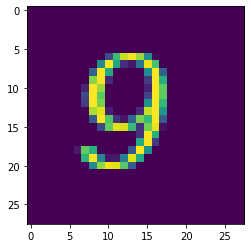

In [12]:
plt.imshow(X_train[5, :, :, 0])
print(Y_train[5])

# Defining the model(still same architecture)

In [223]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

In [224]:
model.compile(optimizer = "adam" , loss = "categorical_crossentropy", metrics=["accuracy"])

In [222]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
early_stopping = EarlyStopping(monitor="val_loss", mode="min", patience=4)

In [131]:
epochs = 50
batch_size = 16

### Defining Image Generator. I have got only 40 images(from example dataset), and I am going to increase that number

In [160]:
datagen = ImageDataGenerator(
        #featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False, # apply ZCA whitening
        rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.15,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.15,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False   # randomly flip images
)  


#datagen = datagen.flow(X_train,Y_train, batch_size=32)

In [204]:
i = 0
datagen.fit(X_train)

# Creating new array for images - it contains 10200 objects more
new_X = np.zeros((10240, 28, 28, 1))
new_X[:40, :, :, :] = X_train

new_Y = np.zeros((10240, 10))
new_Y[:40, :] = Y_train

# Inserting freshly generated images into new datasets
for batch in datagen.flow(X_train, Y_train, batch_size=1):
    new_X[41+i, :, :, :] = batch[0]
    new_Y[41+i, :] = batch[1]
    i += 1
    if i > 10198:
        break
    

In [205]:
print(new_Y[10239])

[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


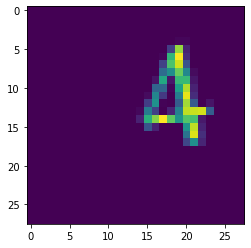

In [206]:
plt.imshow(new_X[10239, :, :, 0])

In [225]:
X_train, X_test, Y_train, Y_test = train_test_split(new_X, new_Y, test_size = 0.15, random_state=42)

# Training model

In [226]:
model.fit(X_train, Y_train, epochs = 50, verbose = 1, validation_split=0.2
                              , 
          callbacks=[learning_rate_reduction, 
        ModelCheckpoint('model_weights_2attempt.h5', verbose=1, save_best_only=True, save_weights_only=True),
                    early_stopping])

Train on 6963 samples, validate on 1741 samples
Epoch 1/50
6963/6963 [==============================] - 40s 6ms/step - loss: 0.9826 - accuracy: 0.6612 - val_loss: 0.1085 - val_accuracy: 0.9673

Epoch 00001: val_loss improved from inf to 0.10847, saving model to model_weights_2attempt.h5
Epoch 2/50


C:\Users\AndriiHura\AppData\Roaming\Python\Python37\site-packages\keras\callbacks\callbacks.py:1042: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


6963/6963 [==============================] - 39s 6ms/step - loss: 0.1336 - accuracy: 0.9575 - val_loss: 0.0840 - val_accuracy: 0.9724

Epoch 00002: val_loss improved from 0.10847 to 0.08396, saving model to model_weights_2attempt.h5
Epoch 3/50
6963/6963 [==============================] - 39s 6ms/step - loss: 0.0681 - accuracy: 0.9789 - val_loss: 0.0135 - val_accuracy: 0.9983

Epoch 00003: val_loss improved from 0.08396 to 0.01345, saving model to model_weights_2attempt.h5
Epoch 4/50
6963/6963 [==============================] - 38s 5ms/step - loss: 0.0442 - accuracy: 0.9843 - val_loss: 0.0198 - val_accuracy: 0.9914

Epoch 00004: val_loss did not improve from 0.01345
Epoch 5/50
6963/6963 [==============================] - 39s 6ms/step - loss: 0.0359 - accuracy: 0.9894 - val_loss: 0.0077 - val_accuracy: 0.9977

Epoch 00005: val_loss improved from 0.01345 to 0.00772, saving model to model_weights_2attempt.h5
Epoch 6/50
6963/6963 [==============================] - 40s 6ms/step - loss: 0.021

# Evaluating accuracy on test dataset

In [227]:
predictions = model.predict_classes(X_test)

In [229]:
predictions

array([6, 5, 1, ..., 4, 7, 2], dtype=int64)

In [234]:
actual = [np.argmax(y) for y in Y_test]
actual

[6,
 5,
 1,
 7,
 5,
 7,
 2,
 0,
 5,
 4,
 4,
 7,
 2,
 5,
 4,
 1,
 7,
 9,
 6,
 8,
 4,
 6,
 4,
 8,
 5,
 8,
 2,
 2,
 1,
 6,
 6,
 4,
 1,
 5,
 4,
 7,
 7,
 7,
 8,
 1,
 4,
 6,
 7,
 8,
 6,
 8,
 7,
 6,
 1,
 4,
 1,
 1,
 2,
 2,
 1,
 7,
 7,
 8,
 2,
 2,
 8,
 4,
 8,
 1,
 6,
 3,
 5,
 7,
 0,
 5,
 7,
 4,
 7,
 9,
 7,
 7,
 7,
 9,
 4,
 6,
 6,
 7,
 2,
 5,
 4,
 2,
 8,
 4,
 2,
 6,
 2,
 6,
 2,
 6,
 6,
 7,
 1,
 4,
 2,
 4,
 8,
 6,
 6,
 5,
 2,
 4,
 1,
 3,
 1,
 1,
 1,
 7,
 1,
 4,
 2,
 9,
 7,
 4,
 8,
 2,
 6,
 8,
 6,
 7,
 2,
 5,
 3,
 9,
 2,
 7,
 7,
 6,
 0,
 1,
 6,
 3,
 7,
 1,
 7,
 0,
 6,
 5,
 3,
 1,
 2,
 8,
 0,
 6,
 1,
 1,
 7,
 8,
 2,
 4,
 4,
 7,
 0,
 2,
 7,
 1,
 4,
 1,
 4,
 1,
 2,
 7,
 1,
 0,
 8,
 9,
 4,
 2,
 1,
 6,
 4,
 4,
 1,
 0,
 7,
 5,
 2,
 1,
 5,
 2,
 9,
 1,
 0,
 0,
 9,
 4,
 4,
 6,
 7,
 5,
 7,
 4,
 1,
 7,
 7,
 1,
 7,
 1,
 2,
 8,
 1,
 2,
 4,
 9,
 2,
 9,
 1,
 8,
 2,
 9,
 7,
 9,
 5,
 2,
 8,
 7,
 7,
 8,
 9,
 2,
 9,
 2,
 9,
 1,
 3,
 7,
 9,
 2,
 2,
 2,
 4,
 1,
 4,
 7,
 1,
 1,
 4,
 2,
 7,
 8,
 5,
 6,
 2,
 9,
 6,
 9,


In [235]:
print(accuracy_score(predictions, actual))

0.9993489583333334
